In [1]:
# ipython kernel install --user --name=venv
import pandas as pd
import numpy as np




import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    mean_squared_error,
    r2_score,
)
from sklearn.tree import export_graphviz
from scipy.stats import randint

In [2]:
CAMPINAS_CODE = "3509502"
SAO_PAULO_CODE = "3550308"
CAPELINHA_CODE = "3112307"
INDAIATUBA_CODE = "3520509"

In [3]:
inep_data = pd.read_csv("../legacy/master_data_2021_v3.csv", delimiter=";")

filtered_data = inep_data[
    (inep_data["NO_CATEGORIA"] == "Total") & (inep_data["NO_DEPENDENCIA"] == "Total")
]

In [8]:
ABANDONO_COLUMN_FUN = "3_CAT_FUN"
ABANDONO_COLUMN_MED ="3_CAT_MED"
EVASAO_COLUMN_FUN = "TXT_FUN_TX_EVASAO_TOTAL"
EVASAO_COLUMN_MED = "TXT_MED_TX_EVASAO_TOTAL"

In [9]:
colunas_interesse = ["ABANDONO_COLUMN_FUN", "ABANDONO_COLUMN_MED", "EVASAO_COLUMN_FUN", "EVASAO_COLUMN_MED"]

filtered_data.rename(columns={
    '3_CAT_FUN': 'ABANDONO_COLUMN_FUN', 
    '3_CAT_MED': 'ABANDONO_COLUMN_MED', 
    '1_CAT3_CATFUN': 'EVASAO_COLUMN_FUN', 
    '1_CAT3_CATMED': 'EVASAO_COLUMN_MED'
    }, inplace=True)

for column in colunas_interesse:
    filtered_data[column] = filtered_data[column].astype(float)

In [10]:
trainning_df = filtered_data.drop(["NU_ANO_CENSO","CO_MUNICIPIO","NO_CATEGORIA","NO_DEPENDENCIA","NO_REGIAO", "NO_UF"], axis=1)
display(trainning_df)


label_encoder = LabelEncoder()
x_categorical = trainning_df.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = trainning_df.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

,ED_INF_CAT_1,ED_INF_CAT_2,ED_INF_CAT_3,ED_INF_CAT_4,ED_INF_CAT_5,ED_INF_CAT_0,EDU_BAS_CAT_5,EDU_BAS_CAT_6,FUN_CAT_1,FUN_CAT_2,...,2_CAT_MED,ABANDONO_COLUMN_FUN,ABANDONO_COLUMN_MED,NO_MUNICIPIO,1_CAT1_CATFUN,1_CAT1_CATMED,1_CAT2_CATFUN,1_CAT2_CATMED,EVASAO_COLUMN_FUN,EVASAO_COLUMN_MED
0,66.2,0.0,20.4,0.0,13.4,15.0,0.0,0.0,27.6,7.6,...,0.5,0.3,0.5,Adamantina,99.7,95.8,0.1,1.4,0.2,0.6
1,74.1,0.0,25.9,0.0,0.0,13.0,0.0,0.0,33.3,12.8,...,0.0,0.0,2.2,Adolfo,98.4,97.0,1.0,0.8,0.6,2.2
2,90.1,0.0,8.9,0.0,1.0,15.9,0.0,7.7,28.6,5.6,...,2.3,0.1,4.8,Aguaí,98.9,95.3,0.5,1.6,0.4,0.9
3,54.8,0.0,41.9,0.0,3.3,17.2,0.0,0.0,26.9,15.4,...,9.2,1.1,6.3,Águas da Prata,99.4,97.5,0.2,0.8,0.4,1.7
4,91.9,0.0,5.9,0.7,1.5,13.0,5.3,5.1,18.5,8.6,...,2.4,0.1,1.0,Águas de Lindóia,91.8,91.4,6.0,5.1,1.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,49.7,0.0,21.8,0.8,27.7,18.9,2.4,1.2,14.7,26.3,...,0.9,0.4,2.5,Votorantim,99.1,95.8,0.3,1.4,0.4,2.3
641,65.2,0.0,32.6,0.0,2.2,18.2,0.0,1.6,16.5,17.7,...,1.2,0.1,0.4,Votuporanga,98.8,96.0,0.7,1.5,0.5,2.3
642,90.0,0.0,0.0,0.0,10.0,9.4,33.3,0.0,26.0,7.4,...,0.0,0.0,0.0,Zacarias,99.1,100.0,0.0,0.0,0.9,0.0
643,41.4,0.0,55.7,0.0,2.9,17.5,8.3,0.0,17.0,6.4,...,0.6,0.4,4.1,Chavantes,99.1,88.3,0.3,5.5,0.5,2.6


In [11]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

y = trainning_df["EVASAO_COLUMN_MED"].values  # Target variable
# Fit the regressor with x and y data
regressor.fit(x_numerical, y)


c:\Users\gabrielgomes\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [12]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(x_numerical)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.9725483294234731
Mean Squared Error: 0.0033936434108527203
R-squared: 0.9992876955216677


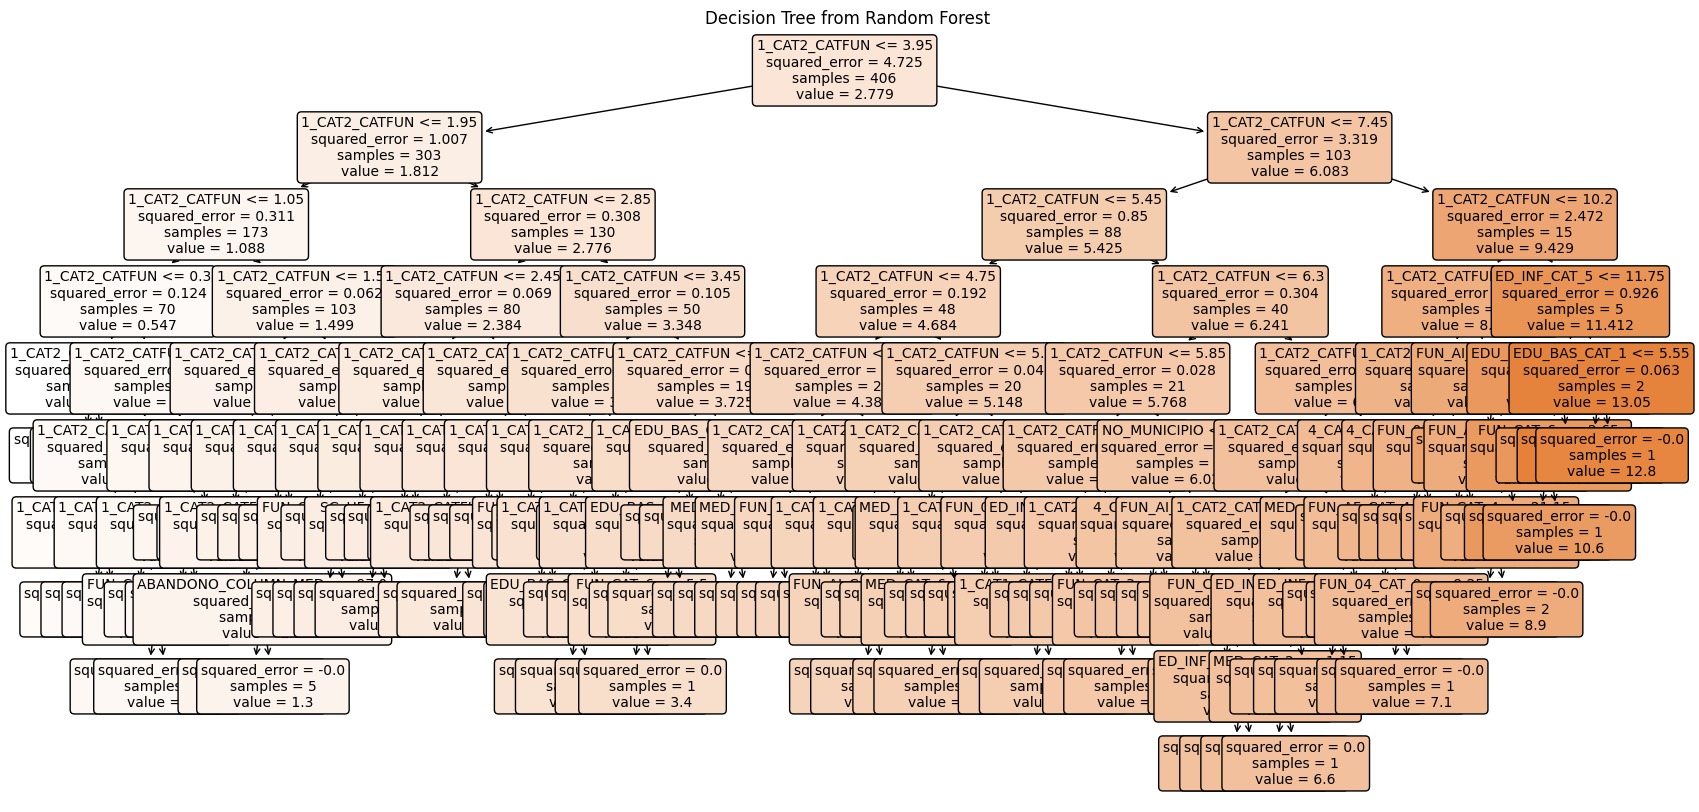

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
 
# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = regressor.estimators_[0]
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=trainning_df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

In [14]:
trainning_df.replace('--', np.nan, inplace=True)
X = trainning_df.drop('EVASAO_COLUMN_MED', axis=1).select_dtypes(exclude=['object']).values
y = trainning_df['EVASAO_COLUMN_MED']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
display(X_train)

array([[64.8,  0.3, 20.4, ...,  0.5,  0.9,  0.6],
       [71.4,  0. , 28.6, ...,  0.2,  1.2,  0.6],
       [57.7,  0. , 17.7, ...,  0.4,  1.7,  0.9],
       ...,
       [85. ,  0. , 10. , ...,  2.1,  0. ,  0.1],
       [78.7,  0. , 13. , ...,  0.5,  1.7,  0.6],
       [69.8,  0.1, 25.3, ...,  1.2,  1.9,  1. ]])

In [17]:
rf = RandomForestRegressor(oob_score=True)
rf.fit(X_train, y_train)

RandomForestRegressor(oob_score=True)

In [18]:
y_pred = rf.predict(X_test)

In [19]:
oob_score = rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)

Out-of-Bag Score: 0.7351970778359628
Mean Squared Error: 1.08170815503876
R-squared: 0.6902408453753222
RMSE:  1.04


In [ ]:
from sklearn.tree import plot_tree

for i in range(3):
    tree = rf.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=trainning_df.columns.tolist(), filled=True, rounded=True, fontsize=10, max_depth=2)
    plt.title("Decision Tree from Random Forest")
    plt.show()

<Axes: >

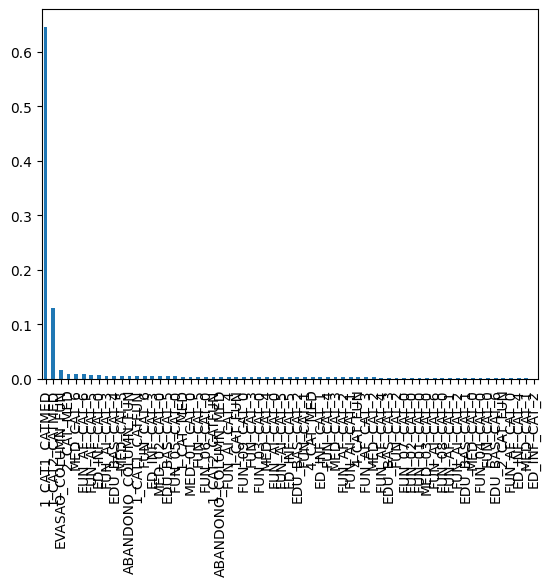

In [21]:
feature_importances = pd.Series(rf.feature_importances_, index=trainning_df.drop('EVASAO_COLUMN_MED', axis=1).select_dtypes(exclude=['object']).columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [22]:
param_dist = {'n_estimators': randint(1,500),
              'max_depth': randint(1,20)}

rf = RandomForestRegressor(oob_score=True)

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=True),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025D5FACA050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025D60683390>})

In [23]:
best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 13, 'n_estimators': 195}


In [24]:
oob_score = best_rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

y_pred = best_rf.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)

Out-of-Bag Score: 0.7461272054264847
Mean Squared Error: 1.075547582173226
R-squared: 0.6920049938972154
RMSE:  1.037


<Axes: >

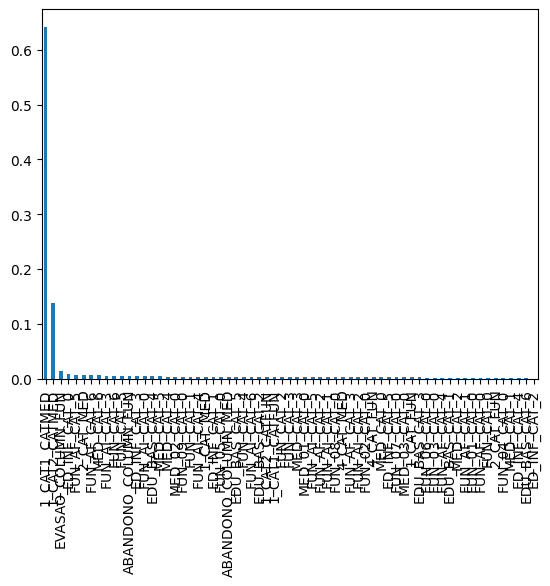

In [25]:
feature_importances = pd.Series(best_rf.feature_importances_, index=trainning_df.drop('EVASAO_COLUMN_MED', axis=1).select_dtypes(exclude=['object']).columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

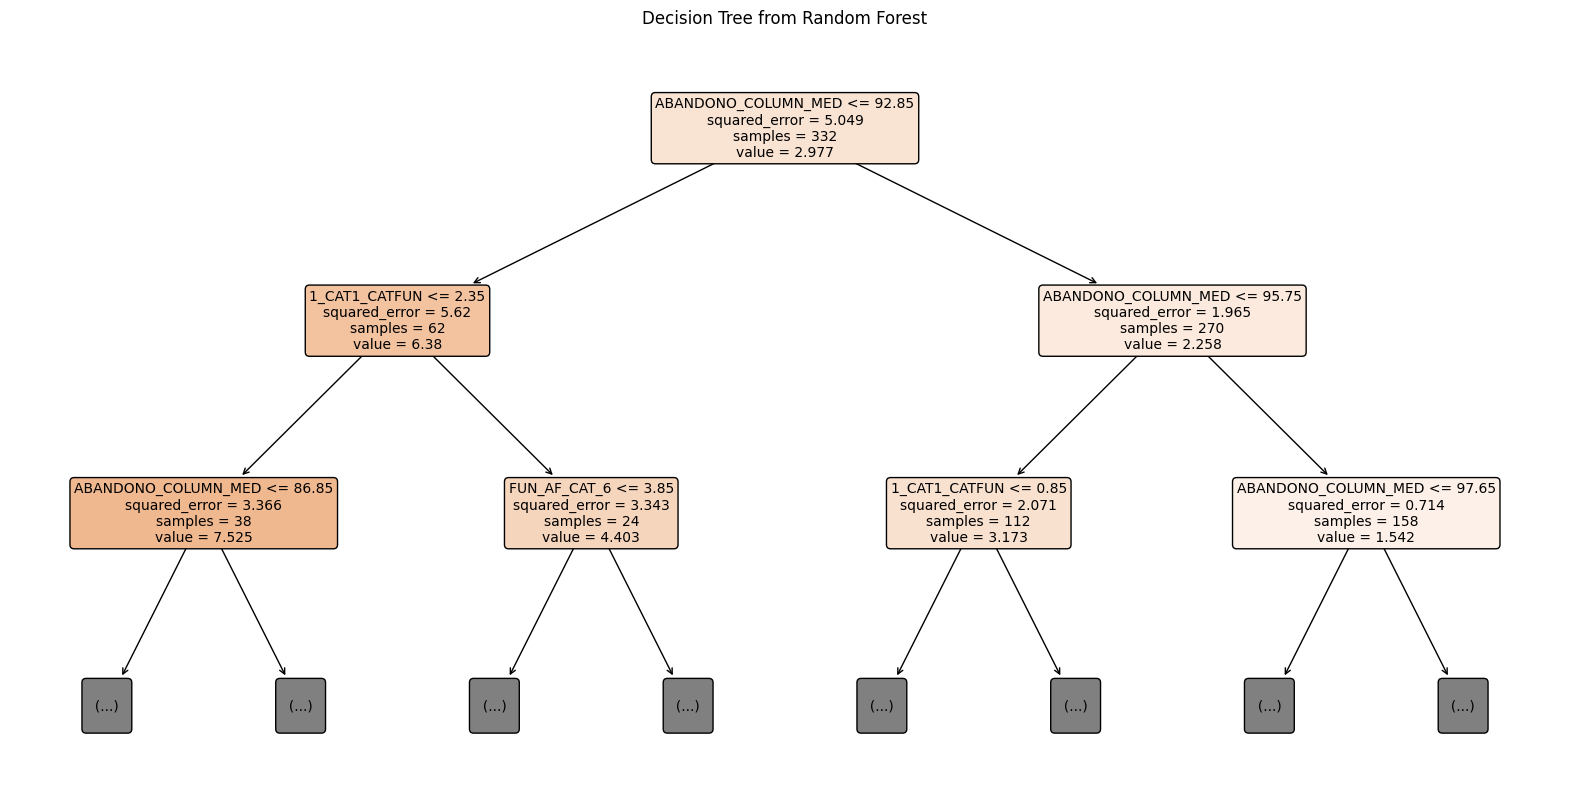

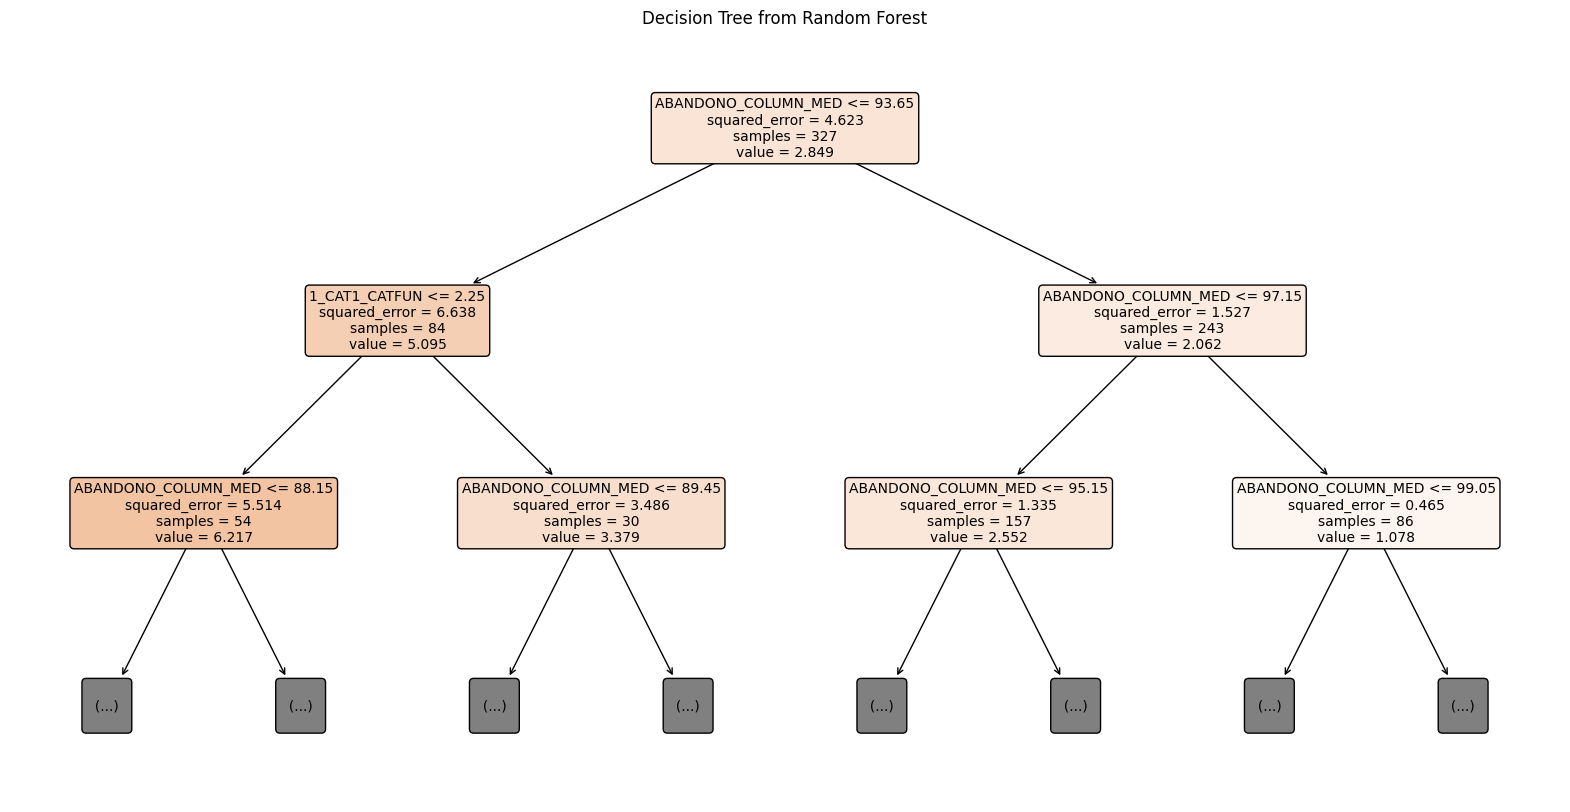

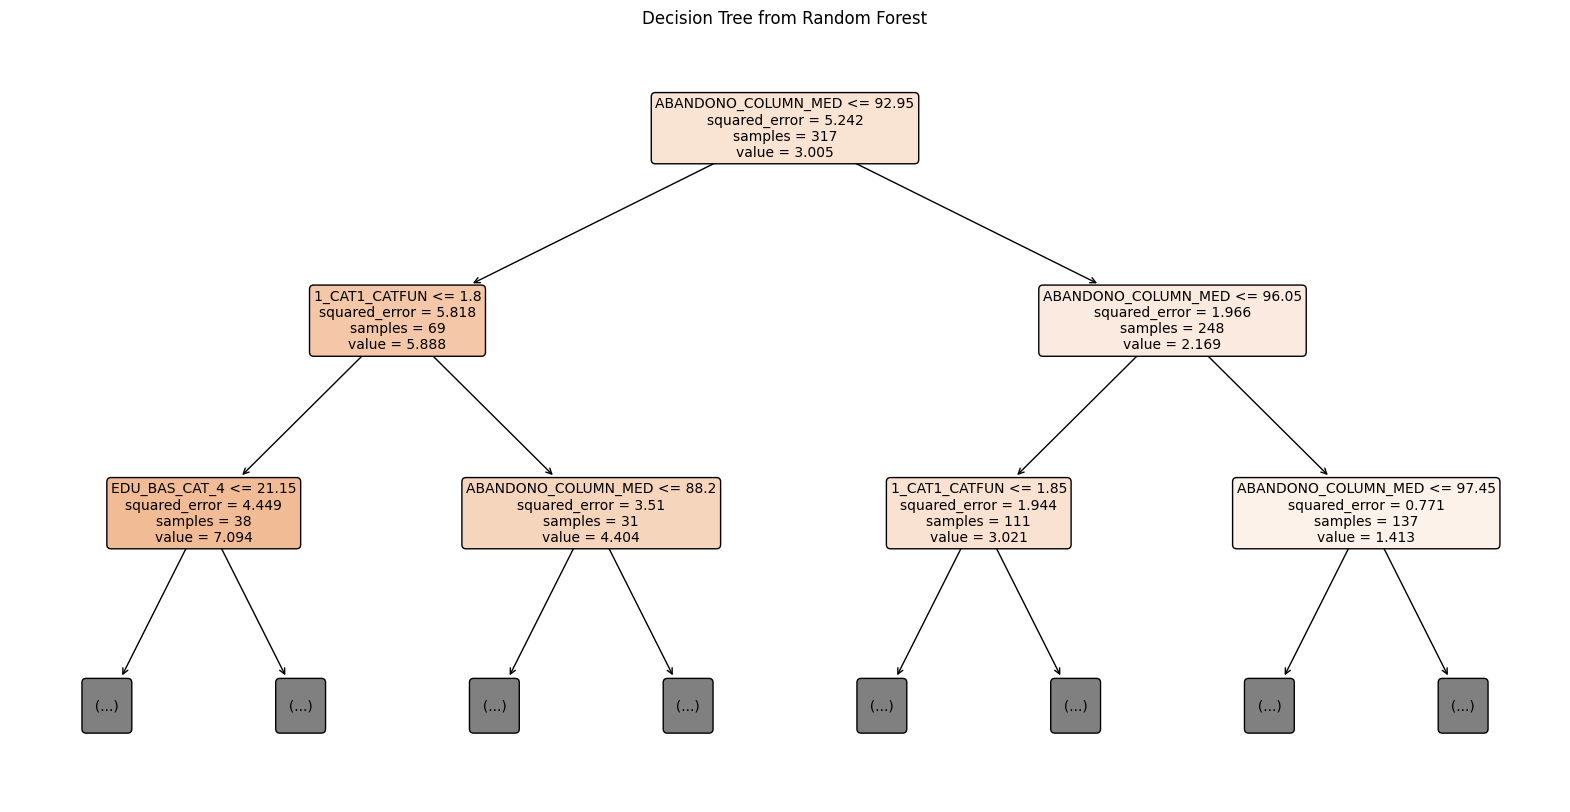

In [26]:
from sklearn.tree import plot_tree

for i in range(3):
    tree = best_rf.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=trainning_df.columns.tolist(), filled=True, rounded=True, fontsize=10, max_depth=2)
    plt.title("Decision Tree from Random Forest")
    plt.show()